In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import random
import numpy as np
import gym
import gym.spaces as sp
from tqdm import trange
from time import sleep
from collections import namedtuple, deque
import matplotlib.pyplot as plt


In [2]:
env = gym.make("CartPole-v1")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cuda


In [3]:
#%% Policy network
class QNet(nn.Module):
    # Policy Network
    def __init__(self, n_states, n_actions, n_hidden=64):
        super(QNet, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(n_states, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_actions)
            )

    def forward(self, x):
        return self.fc(x)


In [4]:
#%% dqn    
class DQN():
    def __init__(self, n_states, n_actions, batch_size=64, lr=1e-4, gamma=0.99, mem_size=int(1e5), learn_step=5, tau=1e-3, only_policy = False, fixed_epsilon = False):
        self.n_states = n_states
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.learn_step = learn_step
        self.tau = tau
        self.only_policy = only_policy
        self.fixed_epsilon = fixed_epsilon
        self.EPS = 0.2

        # model
        self.net_eval = QNet(n_states, n_actions).to(device)
        if not self.only_policy:
            self.net_target = QNet(n_states, n_actions).to(device)
        self.optimizer = optim.Adam(self.net_eval.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

        # memory
        self.memory = ReplayBuffer(n_actions, mem_size, batch_size)
        self.counter = 0    # update cycle counter

    def getAction(self, state, epsilon):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)

        self.net_eval.eval()
        with torch.no_grad():
            action_values = self.net_eval(state)
        self.net_eval.train()

        # epsilon-greedy
        if not self.fixed_epsilon:
            if random.random() < epsilon:
                action = random.choice(np.arange(self.n_actions))
            else:
                action = np.argmax(action_values.cpu().data.numpy())
        else:
            if random.random() < self.EPS:
                action = random.choice(np.arange(self.n_actions))
            else:
                action = np.argmax(action_values.cpu().data.numpy())
        return action

    def save2memory(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        self.counter += 1
        if self.counter % self.learn_step == 0:
            if len(self.memory) >= self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        if not self.only_policy:
            q_target = self.net_target(next_states).detach().max(axis=1)[0].unsqueeze(1)
        else:
            q_target = self.net_eval(next_states).detach().max(axis=1)[0].unsqueeze(1)
        y_j = rewards + self.gamma * q_target * (1 - dones)          # target, if terminal then y_j = rewards
        q_eval = self.net_eval(states).gather(1, actions)

        # loss backprop
        loss = self.criterion(q_eval, y_j)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        if not self.only_policy:
        # soft update target network
            self.softUpdate()

    def softUpdate(self):
        for eval_param, target_param in zip(self.net_eval.parameters(), self.net_target.parameters()):
            target_param.data.copy_(self.tau*eval_param.data + (1.0-self.tau)*target_param.data)




In [5]:
class ReplayBuffer():
    def __init__(self, n_actions, memory_size, batch_size):
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.memory = deque(maxlen = memory_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def __len__(self):
        return len(self.memory)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

In [6]:
def train(env, agent, n_episodes=2000, max_steps=500, eps_start=1.0, eps_end=0.1, eps_decay=0.995, target=500, chkpt=False):
    score_hist = []
    rewards = np.zeros((n_episodes))
    epsilon = eps_start

    bar_format = '{l_bar}{bar:10}| {n:4}/{total_fmt} [{elapsed:>7}<{remaining:>7}, {rate_fmt}{postfix}]'
    # bar_format = '{l_bar}{bar:10}{r_bar}'
    pbar = trange(n_episodes, unit="ep", bar_format=bar_format, ascii=True)
    for idx_epi in pbar:
        state = env.reset()
        score = 0
        for idx_step in range(max_steps):
            action = agent.getAction(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            agent.save2memory(state, action, reward, next_state, done)
            state = next_state
            score += reward

            if done:
                break

        score_hist.append(score)
        rewards[idx_epi] = score
        score_avg = np.mean(score_hist[-200:])
        epsilon = max(eps_end, epsilon*eps_decay)

        pbar.set_postfix_str(f"Score: {score: 7.2f}, 200 score avg: {score_avg: 7.2f}")
        pbar.update(0)
        # if (idx_epi+1) % 100 == 0:
        #     print(" ")
        #     sleep(0.1)

        # Early stop
        if len(score_hist) >= 200:
            if score_avg >= target:
                break

    if (idx_epi+1) < n_episodes:
        print("\nTarget Reached!")
    else:
        print("\nDone!")
        
    if chkpt:
        torch.save(agent.net_eval.state_dict(), 'checkpoint.pth')

    return score_hist, rewards

In [7]:
#%% Test Lunar Lander
def testLander(env, agent, loop=3):
    rewards = np.zeros((loop))
    for i in range(loop):
        state = env.reset()
        for idx_step in range(500):
            action = agent.getAction(state, epsilon=0)
            env.render()
            state, reward, done, _ = env.step(action)
            rewards[i] += reward
            if done:
                break
    env.close()
    return rewards
    

In [8]:
BATCH_SIZE = 128
LR = 1e-3
EPISODES = 3000
TARGET_SCORE = 500.     # early training stop at avg score of last 100 episodes
GAMMA = 0.99            # discount factor
MEMORY_SIZE = 10000     # max memory buffer size
LEARN_STEP = 5          # how often to learn
TAU = 1e-3              # for soft update of target parameters
SAVE_CHKPT = False      # save trained network .pth file


In [9]:
env = gym.make('CartPole-v1')
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n
agent_optimal = DQN(
    n_states = num_states,
    n_actions = num_actions,
    batch_size = BATCH_SIZE,
    lr = LR,
    gamma = GAMMA,
    mem_size = MEMORY_SIZE,
    learn_step = LEARN_STEP,
    tau = TAU,
    only_policy = False,
    fixed_epsilon= False,
    )
score_hist_optimal, train_rewards_optimal = train(env, agent_optimal, n_episodes=EPISODES, target=TARGET_SCORE, chkpt=SAVE_CHKPT)
test_rewards_optimal =  testLander(env, agent_optimal, loop=500)

if str(device) == "cuda":
    torch.cuda.empty_cache()

100%|##########| 3000/3000 [  06:43<  00:00,  7.43ep/s, Score:  104.00, 200 score avg:  105.92]



Done!


In [10]:
env = gym.make('CartPole-v1')
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n
agent_memory = DQN(
    n_states = num_states,
    n_actions = num_actions,
    batch_size = 1,
    lr = LR,
    gamma = GAMMA,
    mem_size = 1,
    learn_step = LEARN_STEP,
    tau = TAU,
    only_policy = False,
    fixed_epsilon= False,
    )
score_hist_memory, train_rewards_memory = train(env, agent_optimal, n_episodes=EPISODES, target=TARGET_SCORE, chkpt=SAVE_CHKPT)
test_rewards_memory =  testLander(env, agent_optimal, loop=500)

if str(device) == "cuda":
    torch.cuda.empty_cache()

100%|##########| 3000/3000 [  08:45<  00:00,  5.71ep/s, Score:  115.00, 200 score avg:  101.36]



Done!


In [11]:
env = gym.make('CartPole-v1')
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n
agent_epsilon = DQN(
    n_states = num_states,
    n_actions = num_actions,
    batch_size = 1,
    lr = LR,
    gamma = GAMMA,
    mem_size = 1,
    learn_step = LEARN_STEP,
    tau = TAU,
    only_policy = False,
    fixed_epsilon= True,
    )
score_hist_epsilon, train_rewards_epsilon = train(env, agent_epsilon, n_episodes=EPISODES, target=TARGET_SCORE, chkpt=SAVE_CHKPT)
test_rewards_epsilon =  testLander(env, agent_epsilon, loop=500)

if str(device) == "cuda":
    torch.cuda.empty_cache()

100%|##########| 3000/3000 [  00:59<  00:00, 50.17ep/s, Score:   27.00, 200 score avg:   20.95] 



Done!


In [12]:
env = gym.make('CartPole-v1')
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n
agent_policy = DQN(
    n_states = num_states,
    n_actions = num_actions,
    batch_size = 1,
    lr = LR,
    gamma = GAMMA,
    mem_size = 1,
    learn_step = LEARN_STEP,
    tau = TAU,
    only_policy = True,
    fixed_epsilon= False,
    )
score_hist_policy, train_rewards_policy = train(env, agent_policy, n_episodes=EPISODES, target=TARGET_SCORE, chkpt=SAVE_CHKPT)
test_rewards_policy =  testLander(env, agent_policy, loop=500)

if str(device) == "cuda":
    torch.cuda.empty_cache()

100%|##########| 3000/3000 [  04:10<  00:00, 11.99ep/s, Score:  344.00, 200 score avg:  172.38]



Done!


In [13]:
import pickle

In [14]:
with open('cartpole_optimal'  + '.pkl', 'wb') as f:
            pickle.dump(train_rewards_optimal, f)
with open('cartpole_policy'  + '.pkl', 'wb') as f:
            pickle.dump(train_rewards_policy, f)
with open('cartpole_memory'  + '.pkl', 'wb') as f:
            pickle.dump(train_rewards_memory, f)
with open('cartpole_epsilon'  + '.pkl', 'wb') as f:
            pickle.dump(train_rewards_epsilon, f)


In [19]:
mean_optimal_train = np.mean(train_rewards_optimal)
std_optimal_train = np.std(train_rewards_optimal)
mean_policy_train = np.mean(train_rewards_policy)
std_policy_train = np.std(train_rewards_policy)
mean_memory_train = np.mean(train_rewards_memory)
std_memory_train = np.std(train_rewards_memory)
mean_epsilon_train = np.mean(train_rewards_epsilon)
std_epsilon_train = np.std(train_rewards_epsilon)


In [25]:
mean_optimal_test = np.mean(test_rewards_optimal)
std_optimal_test = np.std(test_rewards_optimal)
mean_policy_test = np.mean(test_rewards_policy)
std_policy_test = np.std(test_rewards_policy)
mean_memory_test = np.mean(test_rewards_memory)
std_memory_test = np.std(test_rewards_memory)
mean_epsilon_test = np.mean(test_rewards_epsilon)
std_epsilon_test = np.std(test_rewards_epsilon)

In [26]:
print(mean_optimal_test)
print(mean_epsilon_test)
print(mean_memory_test)
print(mean_policy_test)

152.218
23.078
500.0
265.858


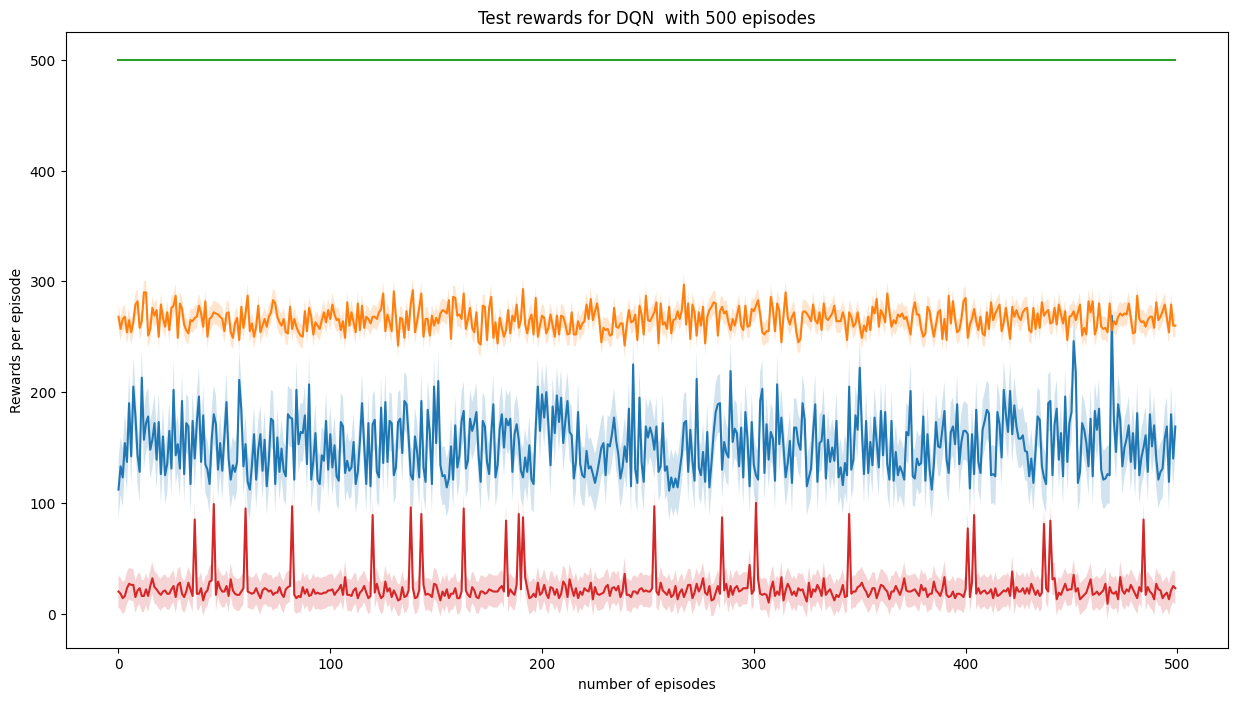

In [28]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(range(500), test_rewards_optimal, label=f"Optimal Agent preformance on test episodes")
ax.fill_between(range(500), test_rewards_optimal - std_optimal_test, test_rewards_optimal + std_optimal_test, alpha=0.2)
ax.plot(range(500), test_rewards_policy, label=f"No target network Agent preformance on test episodes")
ax.fill_between(range(500), test_rewards_policy - std_policy_test, test_rewards_policy + std_policy_test, alpha=0.2)
ax.plot(range(500), test_rewards_memory, label=f"No memory Agent preformance on test episodes")
ax.fill_between(range(500), test_rewards_memory - std_memory_test, test_rewards_memory + std_memory_test, alpha=0.2)
ax.plot(range(500), test_rewards_epsilon, label=f"Agent with fixed exploration Training Rewards")
ax.fill_between(range(500), test_rewards_epsilon - std_epsilon_test, test_rewards_epsilon + std_epsilon_test, alpha=0.2)
ax.set_xlabel("number of episodes")
ax.set_ylabel("Rewards per episode")
# ax.legend()
ax.set_title(f"Test rewards for DQN  with 500 episodes")
plt.show()

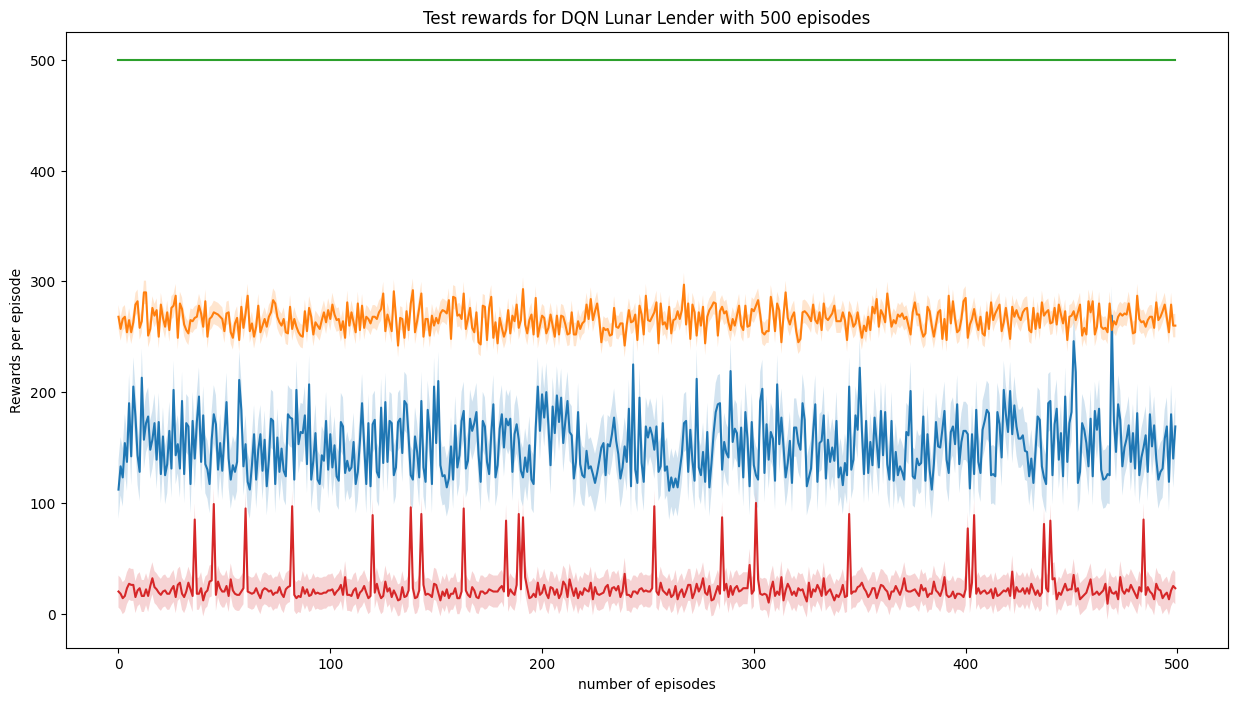

In [27]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(range(500), test_rewards_optimal, label=f"Optimal Agent preformance on test episodes")
ax.fill_between(range(500), test_rewards_optimal - std_optimal_test, test_rewards_optimal + std_optimal_test, alpha=0.2)
ax.plot(range(500), test_rewards_policy, label=f"No target network Agent preformance on test episodes")
ax.fill_between(range(500), test_rewards_policy - std_policy_test, test_rewards_policy + std_policy_test, alpha=0.2)
ax.plot(range(500), test_rewards_memory, label=f"No memory Agent preformance on test episodes")
ax.fill_between(range(500), test_rewards_memory - std_memory_test, test_rewards_memory + std_memory_test, alpha=0.2)
ax.plot(range(500), test_rewards_epsilon, label=f"Agent with fixed exploration Training Rewards")
ax.fill_between(range(500), test_rewards_epsilon - std_epsilon_test, test_rewards_epsilon + std_epsilon_test, alpha=0.2)
ax.set_xlabel("number of episodes")
ax.set_ylabel("Rewards per episode")
ax.set_title(f"Test rewards for DQN Lunar Lender with 500 episodes")
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1000,) and (0,)

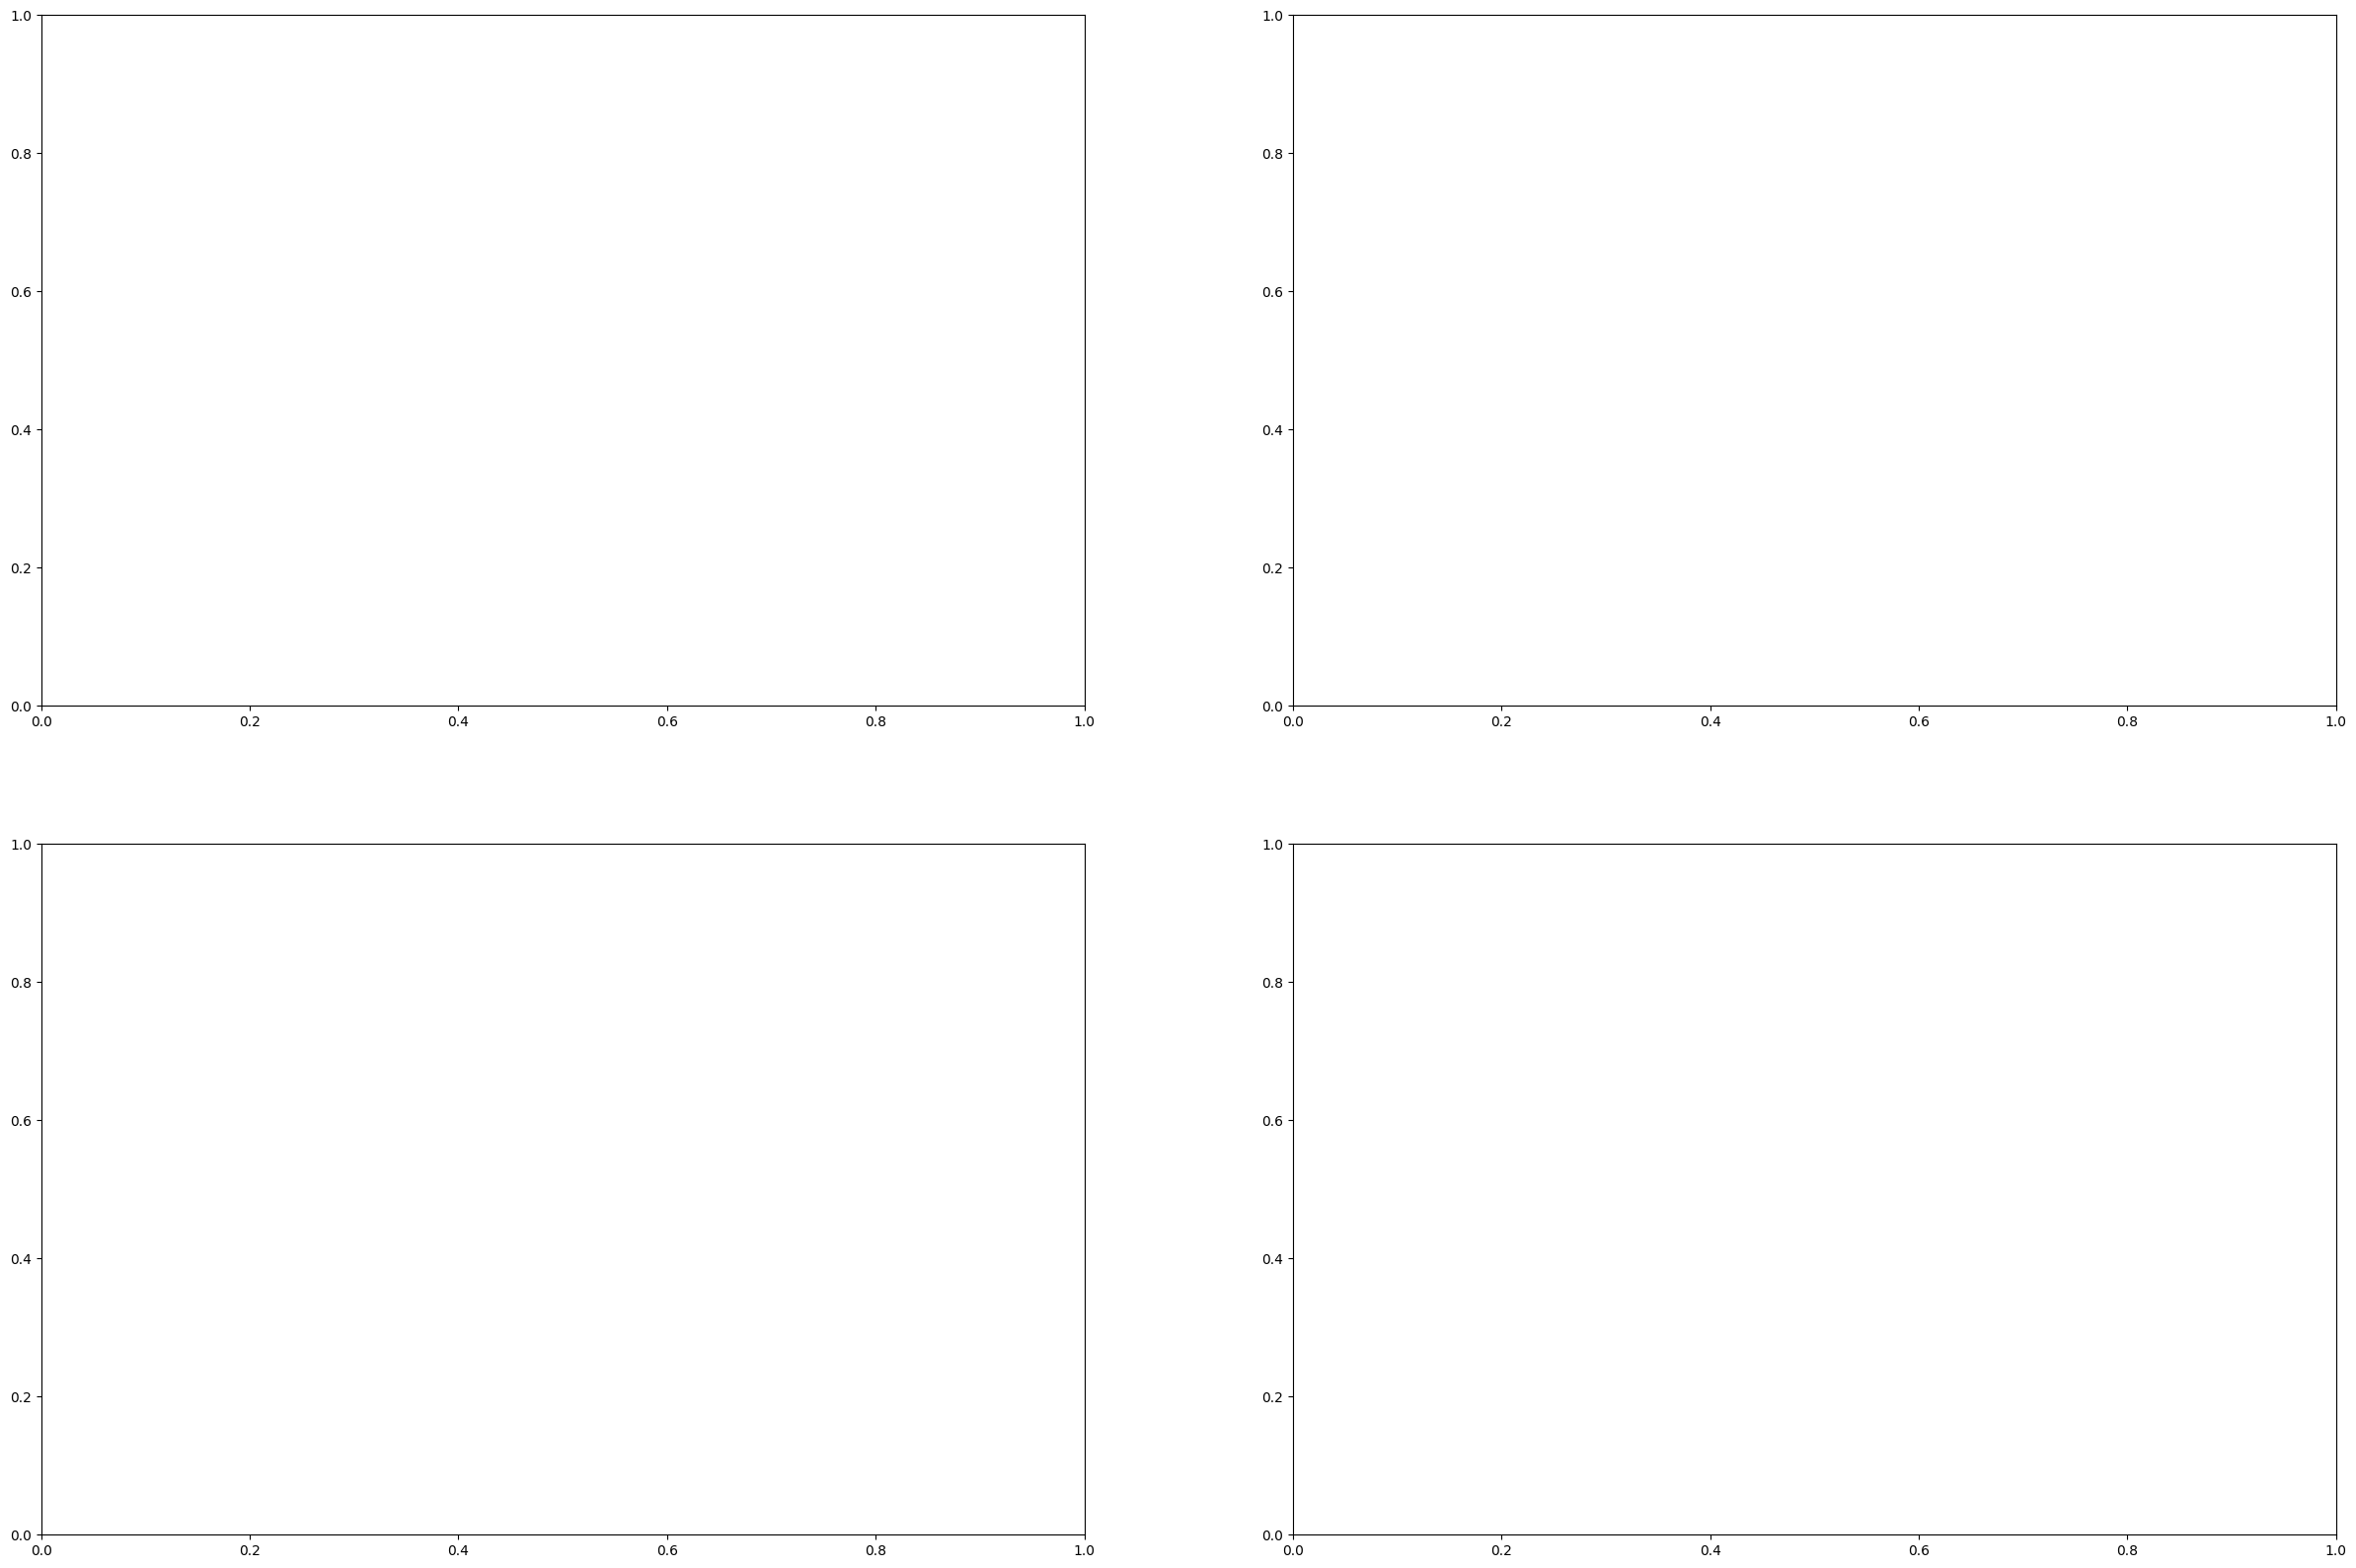

In [18]:
fig,ax = plt.subplots(nrows=2,ncols = 2, figsize=(30,20))
ax[0,0].plot(range(1000), train_rewards_optimal[4000:5000], label=f"Optimal Agent Training Rewards")
# ax[0,0].fill_between(range(EPISODES), train_rewards_optimal - std_optimal_train, train_rewards_optimal + std_optimal_train, alpha=0.2)
ax[1,0].plot(range(1000), train_rewards_policy[4000:5000], label=f"Agent with only one network Training Rewards")
# ax[1,0].fill_between(range(EPISODES), train_rewards_policy - std_policy_train, train_rewards_policy + std_policy_train, alpha=0.2)
ax[0,1].plot(range(1000), train_rewards_memory[4000:5000], label=f"Agent without memory Training Rewards")
# ax[0,1].fill_between(range(EPISODES), train_rewards_memory - std_memory_train, train_rewards_memory + std_memory_train, alpha=0.2)
ax[1,1].plot(range(1000), train_rewards_epsilon[4000:5000], label=f"Agent with fixed exploration Training Rewards")
# ax[1,1].fill_between(range(EPISODES), train_rewards_epsilon - std_epsilon_train, train_rewards_epsilon + std_epsilon_train, alpha=0.2)
# ax.set_xlabel("number of episodes")
# legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
# ax.set_ylabel("Reward averaged over 10 inndependent runs")
ax[0,0].set_title(f"Optimal Agent Training Rewards")
ax[1,0].set_title(f"Agent with only one network Training Rewards")
ax[0,1].set_title(f"Agent without memory Training Rewards")
ax[1,1].set_title(f"Agent with fixed exploration Training Rewards")
plt.show()


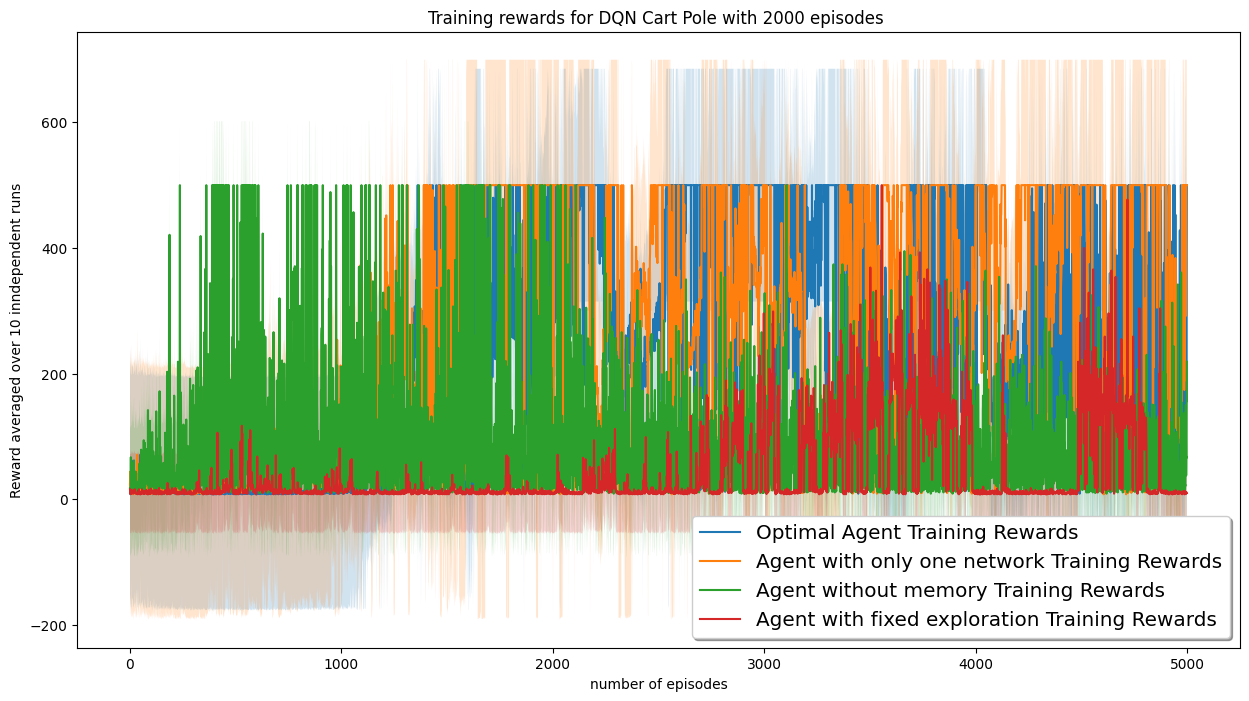

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(range(EPISODES), train_rewards_optimal, label=f"Optimal Agent Training Rewards")
ax.fill_between(range(EPISODES), train_rewards_optimal - std_optimal_train, train_rewards_optimal + std_optimal_train, alpha=0.2)
ax.plot(range(EPISODES), train_rewards_policy, label=f"Agent with only one network Training Rewards")
ax.fill_between(range(EPISODES), train_rewards_policy - std_policy_train, train_rewards_policy + std_policy_train, alpha=0.2)
ax.plot(range(EPISODES), train_rewards_memory, label=f"Agent without memory Training Rewards")
ax.fill_between(range(EPISODES), train_rewards_memory - std_memory_train, train_rewards_memory + std_memory_train, alpha=0.2)
ax.plot(range(EPISODES), train_rewards_epsilon, label=f"Agent with fixed exploration Training Rewards")
ax.fill_between(range(EPISODES), train_rewards_epsilon - std_epsilon_train, train_rewards_epsilon + std_epsilon_train, alpha=0.2)
ax.set_xlabel("number of episodes")
legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
ax.set_ylabel("Reward averaged over 10 inndependent runs")
ax.set_title(f"Training rewards for DQN Cart Pole with 2000 episodes ")
plt.show()

In [ ]:
mean_optimal_test = np.mean(test_rewards_optimal)
std_optimal_test = np.std(test_rewards_optimal)
mean_policy_test = np.mean(test_rewards_policy)
std_policy_test = np.std(test_rewards_policy)
mean_memory_test = np.mean(test_rewards_memory)
std_memory_test = np.std(test_rewards_memory)
mean_epsilon_test = np.mean(test_rewards_epsilon)
std_epsilon_test = np.std(test_rewards_epsilon)

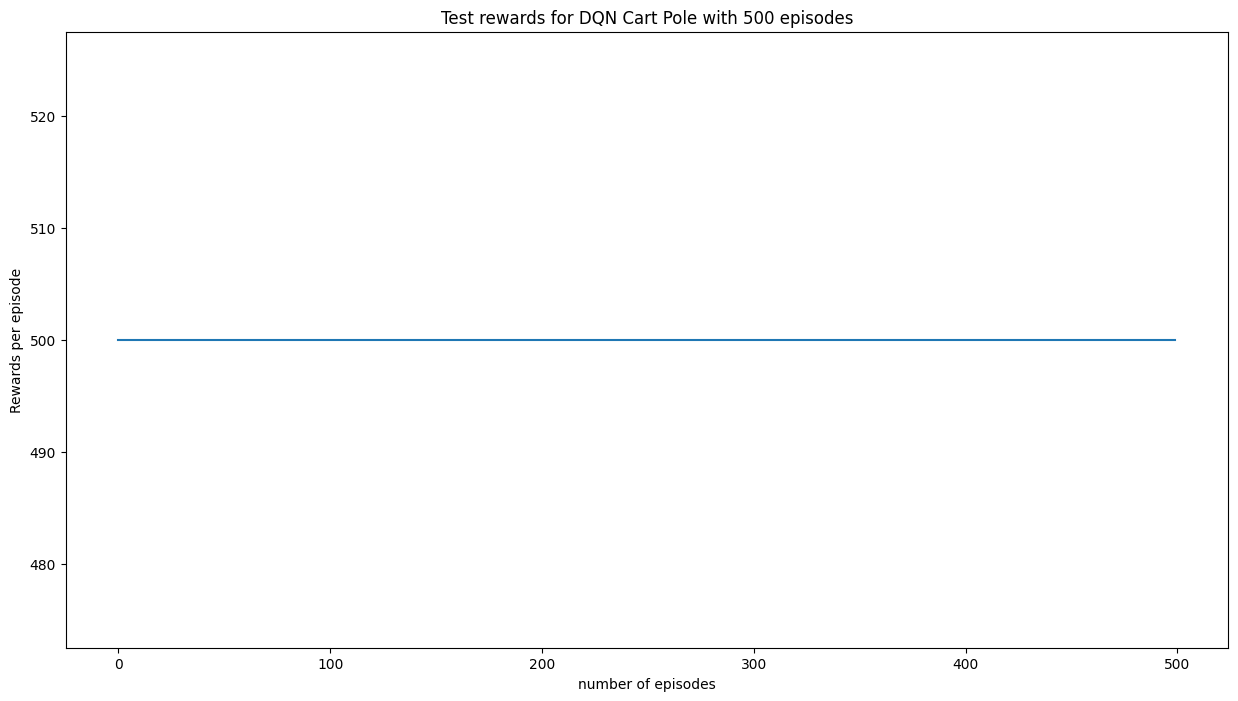

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(range(500), test_rewards_optimal, label=f"Optimal Agent preformance on test episodes")
ax.fill_between(range(500), test_rewards_optimal - std_optimal_test, test_rewards_optimal + std_optimal_test, alpha=0.2)
ax.plot(range(500), test_rewards_policy, label=f"No target network Agent preformance on test episodes")
ax.fill_between(range(500), test_rewards_policy - std_policy_test, test_rewards_policy + std_policy_test, alpha=0.2)
ax.plot(range(500), test_rewards_memory, label=f"No memory Agent preformance on test episodes")
ax.fill_between(range(500), test_rewards_memory - std_memory_test, test_rewards_memory + std_memory_test, alpha=0.2)
ax.plot(range(500), test_rewards_epsilon, label=f"Agent with fixed exploration Training Rewards")
ax.fill_between(range(500), test_rewards_epsilon - std_epsilon_test, test_rewards_epsilon + std_epsilon_test, alpha=0.2)
ax.set_xlabel("number of episodes")
ax.set_ylabel("Rewards per episode")
ax.set_title(f"Test rewards for DQN Cart Pole with 500 episodes")
plt.show()